# YZM304 4. Ödev – Autoencoder Karşılaştırma (PyTorch)
Öğrenci: **[Eriş Söylemez]**  
Numara: **[22290702]**


In [ ]:
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_subset = Subset(mnist_train, range(20000))
test_subset  = Subset(mnist_test,  range(5000))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_subset,  batch_size=128, shuffle=False, num_workers=0)

In [ ]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1,28,28))
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class StackedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1,28,28))
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train_autoencoder(model, loader, epochs=10, lr=1e-2):
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = []

    for ep in range(epochs):
        run_loss = 0.0
        model.train()
        for xb, _ in loader:
            xb = xb.to(device)
            optim.zero_grad()
            recon = model(xb)
            loss = criterion(recon, xb)
            loss.backward()
            optim.step()
            run_loss += loss.item() * xb.size(0)
        ep_loss = run_loss / len(loader.dataset)
        history.append(ep_loss)
        print(f'Epoch {ep+1}/{epochs} - Loss: {ep_loss:.4f}')
    return history

Epoch 1/10 - Loss: 0.0496
Epoch 2/10 - Loss: 0.0231
Epoch 3/10 - Loss: 0.0163
Epoch 4/10 - Loss: 0.0134
Epoch 5/10 - Loss: 0.0118
Epoch 6/10 - Loss: 0.0108
Epoch 7/10 - Loss: 0.0099
Epoch 8/10 - Loss: 0.0094
Epoch 9/10 - Loss: 0.0089
Epoch 10/10 - Loss: 0.0085


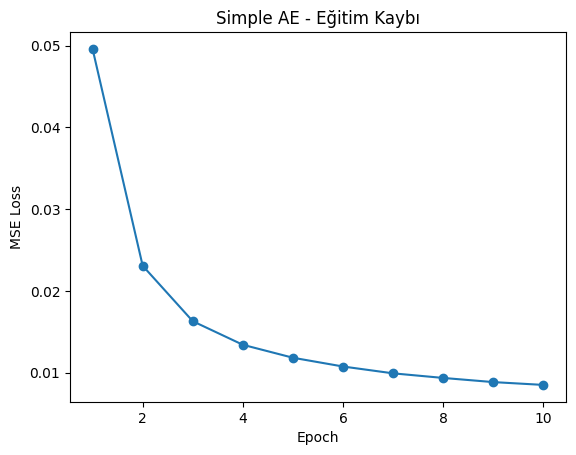

In [ ]:
simple_ae = SimpleAutoencoder()
loss_simple = train_autoencoder(simple_ae, train_loader, epochs=10)

plt.plot(range(1, len(loss_simple)+1), loss_simple, marker='o')
plt.title('Simple AE - Eğitim Kaybı')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.show()

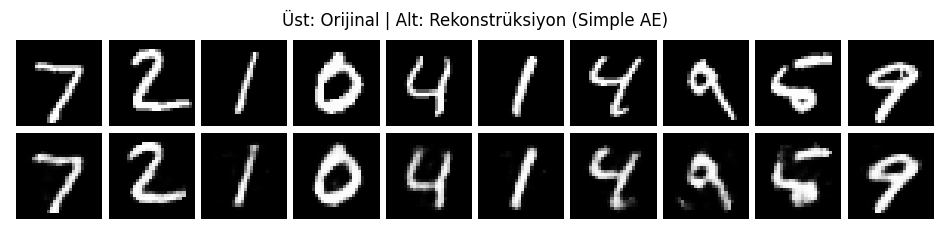

In [ ]:
from torchvision.utils import make_grid
simple_ae.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    imgs, _ = next(data_iter)
    sample = imgs[:10].to(device)
    recon  = simple_ae(sample).cpu()
grid = make_grid(torch.cat([sample.cpu(), recon], 0), nrow=10, pad_value=1)
plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0), cmap='gray')
plt.axis('off')
plt.title('Üst: Orijinal | Alt: Rekonstrüksiyon (Simple AE)')
plt.show()

Simple AE + LR Accuracy: 88.82 %


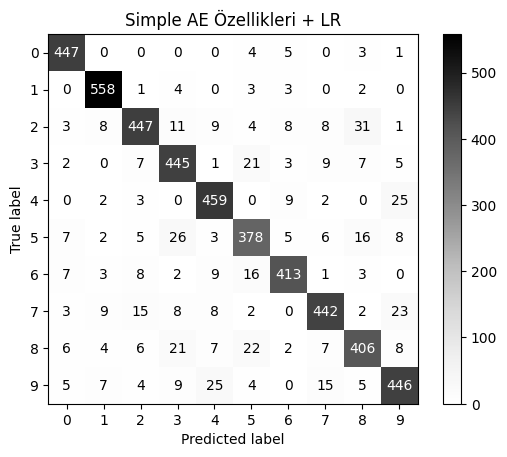

In [ ]:
def extract_features(model, loader):
    feats, labels = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            z = model.encoder(xb.to(device)).cpu()
            feats.append(z); labels.append(yb)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy()

X_train_s, y_train_s = extract_features(simple_ae, train_loader)
X_test_s,  y_test_s  = extract_features(simple_ae, test_loader)

scaler_s = StandardScaler().fit(X_train_s)
clf_s = LogisticRegression(max_iter=1000).fit(scaler_s.transform(X_train_s), y_train_s)
y_pred_s = clf_s.predict(scaler_s.transform(X_test_s))
acc_s = accuracy_score(y_test_s, y_pred_s)
print('Simple AE + LR Accuracy:', acc_s*100, '%')

ConfusionMatrixDisplay.from_predictions(y_test_s, y_pred_s, cmap='Greys')
plt.title('Simple AE Özellikleri + LR')
plt.show()

Epoch 1/20 - Loss: 0.0661
Epoch 2/20 - Loss: 0.0371
Epoch 3/20 - Loss: 0.0290
Epoch 4/20 - Loss: 0.0254
Epoch 5/20 - Loss: 0.0226
Epoch 6/20 - Loss: 0.0208
Epoch 7/20 - Loss: 0.0197
Epoch 8/20 - Loss: 0.0185
Epoch 9/20 - Loss: 0.0175
Epoch 10/20 - Loss: 0.0170
Epoch 11/20 - Loss: 0.0160
Epoch 12/20 - Loss: 0.0158
Epoch 13/20 - Loss: 0.0149
Epoch 14/20 - Loss: 0.0145
Epoch 15/20 - Loss: 0.0141
Epoch 16/20 - Loss: 0.0138
Epoch 17/20 - Loss: 0.0133
Epoch 18/20 - Loss: 0.0130
Epoch 19/20 - Loss: 0.0127
Epoch 20/20 - Loss: 0.0125


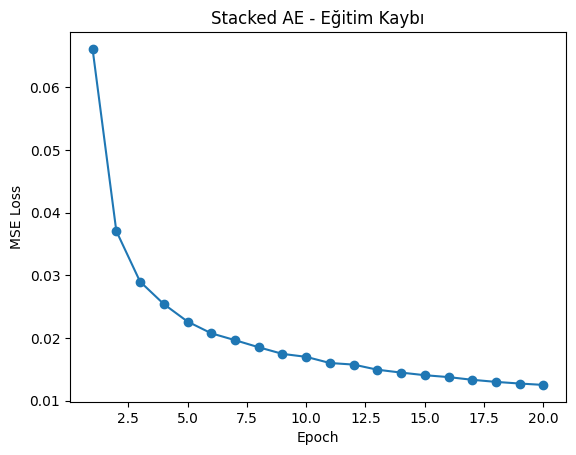

Stacked AE + LR Accuracy: 87.8 %


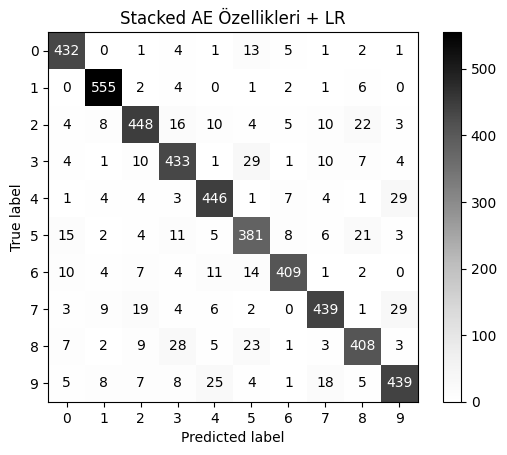

In [ ]:
stacked_ae = StackedAutoencoder()
loss_stacked = train_autoencoder(stacked_ae, train_loader, epochs=20)

plt.plot(range(1, len(loss_stacked)+1), loss_stacked, marker='o')
plt.title('Stacked AE - Eğitim Kaybı')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.show()

X_train_st, y_train_st = extract_features(stacked_ae, train_loader)
X_test_st,  y_test_st  = extract_features(stacked_ae, test_loader)

scaler_st = StandardScaler().fit(X_train_st)
clf_st = LogisticRegression(max_iter=1000).fit(scaler_st.transform(X_train_st), y_train_st)
y_pred_st = clf_st.predict(scaler_st.transform(X_test_st))
acc_st = accuracy_score(y_test_st, y_pred_st)
print('Stacked AE + LR Accuracy:', acc_st*100, '%')

ConfusionMatrixDisplay.from_predictions(y_test_st, y_pred_st, cmap='Greys')
plt.title('Stacked AE Özellikleri + LR')
plt.show()

Ham Piksel + LR Accuracy: 86.94 %


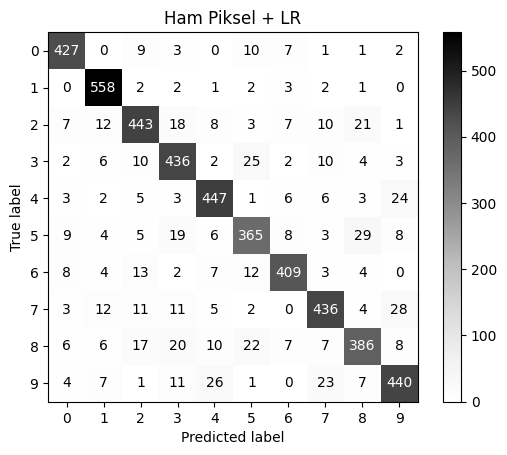

In [ ]:
def flatten_loader(dataset):
    xs, ys = [], []
    for img, label in dataset:
        xs.append(img.view(-1).numpy())
        ys.append(label)
    return np.stack(xs), np.array(ys)

X_train_raw, y_train_raw = flatten_loader(train_subset)
X_test_raw,  y_test_raw  = flatten_loader(test_subset)

scaler_raw = StandardScaler().fit(X_train_raw)
clf_raw = LogisticRegression(max_iter=1000).fit(scaler_raw.transform(X_train_raw), y_train_raw)
y_pred_raw = clf_raw.predict(scaler_raw.transform(X_test_raw))
acc_raw = accuracy_score(y_test_raw, y_pred_raw)
print('Ham Piksel + LR Accuracy:', acc_raw*100, '%')

ConfusionMatrixDisplay.from_predictions(y_test_raw, y_pred_raw, cmap='Greys')
plt.title('Ham Piksel + LR')
plt.show()